In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input 
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping



2025-01-04 15:06:35.614083: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


*CMAPSS*

The columns of the CMAPSS dataset correspond to:
1) Engine IDs unit number
2) Engine Cycles time, in cycles
3) operational setting 1
4) operational setting 2
5) operational setting 3
6) sensor measurement 1
7) sensor measurement 2
...
26) sensor measurement 26
(Pressure.
Temperature.
Fan speed.
Core speed.
Fuel flow rate.)



Data Set: FD001
Train trjectories: 100
Test trajectories: 100
Conditions: ONE (Sea Level)
Fault Modes: ONE (HPC Degradation)

Data Set: FD002
Train trjectories: 260
Test trajectories: 259
Conditions: SIX
Fault Modes: ONE (HPC Degradation)

Data Set: FD003
Train trjectories: 100
Test trajectories: 100
Conditions: ONE (Sea Level)
Fault Modes: TWO (HPC Degradation, Fan Degradation)

Data Set: FD004
Train trjectories: 248
Test trajectories: 249
Conditions: SIX
Fault Modes: TWO (HPC Degradation, Fan Degradation)


In [2]:
# Load datasets
# choose between FD001, FD002, FD003, FD004
dataset = 'FD001'
train = pd.read_csv(f'Data/CMAPSS/train_{dataset}.txt',sep=' ', header=None)
test = pd.read_csv(f'Data/CMAPSS/test_{dataset}.txt',sep=' ', header=None)
rul = pd.read_csv(f'Data/CMAPSS/RUL_{dataset}.txt', header=None)

train = train.dropna(axis= 1)
test = test.dropna(axis= 1)

train.columns = ['unit', 'time', 'setting1', 'setting2', 'setting3'] + [f'sensor_{i}' for i in range(1, 22)]
test.columns = ['unit', 'time', 'setting1', 'setting2', 'setting3'] + [f'sensor_{i}' for i in range(1, 22)]
rul.columns = ['RUL']
train


,unit,time,setting1,setting2,setting3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


Calculate the RUL for each engine in the training dataset.

In [3]:
# Add RUL to training data
max_cycle_per_unit = train.groupby('unit')['time'].max()
train['RUL'] = max_cycle_per_unit[train['unit']].values - train['time']

train['RUL']

0        191
1        190
2        189
3        188
4        187
        ... 
20626      4
20627      3
20628      2
20629      1
20630      0
Name: RUL, Length: 20631, dtype: int64

In [4]:

# Select features to normalize (operational settings and sensor measurements)
features_to_normalize = ['setting1', 'setting2', 'setting3'] + [f'sensor_{i}' for i in range(1, 22)]

# Apply Min-Max Scaling
scaler = MinMaxScaler()
train[features_to_normalize] = scaler.fit_transform(train[features_to_normalize])
test[features_to_normalize] = scaler.transform(test[features_to_normalize])

train.head()

,unit,time,setting1,setting2,setting3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187


Generate input sequences for training the model. Use sliding windows to create sequences of sensor data for each engine.

In [5]:
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for unit in data['unit'].unique():
        unit_data = data[data['unit'] == unit]
        for i in range(len(unit_data) - sequence_length):
            seq = unit_data.iloc[i:i + sequence_length][features_to_normalize].values
            label = unit_data.iloc[i + sequence_length - 1]['RUL']
            sequences.append(seq)
            labels.append(label)
    return np.array(sequences), np.array(labels)



# Create sequences for training data
sequence_length = 30
X_train, y_train = create_sequences(train, sequence_length=sequence_length)


Create test sequences and use the RUL file for the ground truth RUL.


In [6]:
# Create test sequences
def prepare_test_data(test_data, rul_data, sequence_length=30):
    sequences = []
    labels = []
    for i, unit in enumerate(test_data['unit'].unique()):
        unit_data = test_data[test_data['unit'] == unit]
        # Use the last `sequence_length` cycles for each engine
        seq = unit_data.iloc[-sequence_length:][features_to_normalize].values
        sequences.append(seq)
        # The RUL is provided directly in the RUL file
        labels.append(rul_data.iloc[i]['RUL'])
    return np.array(sequences), np.array(labels)

X_test, y_test = prepare_test_data(test, rul, sequence_length=sequence_length)

Initial Labeled Data: (50, 30, 24)
Initial Unlabeled Data: (17581, 30, 24)


In [8]:

# Define the model
model = Sequential([
    LSTM(128, activation='relu', return_sequences=False, input_shape=(sequence_length, len(features_to_normalize))),
    Dropout(0.35),
    Dense(32, activation='relu'),
    Dropout(0.35),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Best Configuration: {'learning_rate': 0.001, 'dropout_rate': 0.35, 'epochs': 30, 'batch_size': 16, 'test_loss': 329.05718994140625, 'test_mae': 12.569485664367676}
#early stopping
#early_stopping = EarlyStopping(monitor='val_loss', patience=10)


# Train the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=16)

# plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()




Active Learning Iteration 1/10

Active Learning Iteration 2/10

Active Learning Iteration 3/10

Active Learning Iteration 4/10

Active Learning Iteration 5/10

Active Learning Iteration 6/10

Active Learning Iteration 7/10

Active Learning Iteration 8/10

Active Learning Iteration 9/10

Active Learning Iteration 10/10


Model evaluation

In [10]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Predict RUL for test data
y_pred = model.predict(X_test)

# Compare predictions with true RUL
plt.figure(figsize=(30, 10))
plt.plot(y_test, label='True RUL', marker='o')
plt.plot(y_pred, label='Predicted RUL', marker='x')
plt.xlabel('Engine Index')
plt.ylabel('RUL')
plt.legend()
plt.title('True vs Predicted RUL')
plt.show()


Epoch 1/30
3/3 [==============================] - 2s 148ms/step - loss: 14082.5205 - mae: 100.2538 - val_loss: 13602.4424 - val_mae: 98.6901
Epoch 2/30
3/3 [==============================] - 0s 24ms/step - loss: 14027.4893 - mae: 99.9841 - val_loss: 13551.5283 - val_mae: 98.4364
Epoch 3/30
3/3 [==============================] - 0s 25ms/step - loss: 13952.5127 - mae: 99.5954 - val_loss: 13453.1924 - val_mae: 97.9408
Epoch 4/30
3/3 [==============================] - 0s 23ms/step - loss: 13743.8750 - mae: 98.6376 - val_loss: 12545.0273 - val_mae: 92.9185
Epoch 5/30
3/3 [==============================] - 0s 23ms/step - loss: 10738.9805 - mae: 85.1725 - val_loss: 5516.6523 - val_mae: 56.9831
Epoch 6/30
3/3 [==============================] - 0s 26ms/step - loss: 7281.3062 - mae: 68.3873 - val_loss: 7219.7915 - val_mae: 63.8057
Epoch 7/30
3/3 [==============================] - 0s 25ms/step - loss: 6486.7661 - mae: 63.5522 - val_loss: 5290.6250 - val_mae: 60.4319
Epoch 8/30
3/3 [==============

Labeled Data Size: 60
Unlabeled Data Size: 17571
4/4 [==============================] - 0s 5ms/step - loss: 946.5100 - mae: 25.2847

Final Test Loss: 946.510009765625, Final Test MAE: 25.284685134887695
4/4 [==============================] - 0s 5ms/step


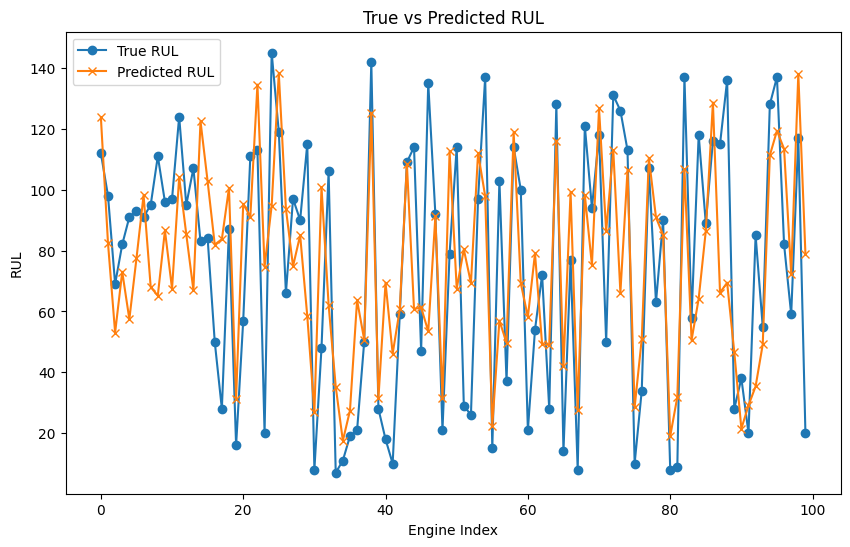

In [11]:
# Hyperparameter Tuning
# Define a function to build the model
def build_model(learning_rate, dropout_rate):
    model = Sequential([
        LSTM(128, activation='relu', return_sequences=False, input_shape=(sequence_length, len(features_to_normalize))),
        Dropout(dropout_rate),
        Dense(32, activation='relu'),
        Dropout(dropout_rate),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model

# Hyperparameter grid
param_grid = {
    'learning_rate': [0.0001, 0.0005, 0.001, 0.005],
    'dropout_rate': [0.2, 0.3,0.35, 0.4],
    'epochs': [30, 50, 100, 150, 200],
    'batch_size': [16, 32, 64,128]
}

# To store the results
results = []

# Grid search
for learning_rate in param_grid['learning_rate']:
    for dropout_rate in param_grid['dropout_rate']:
        for epochs in param_grid['epochs']:
            for batch_size in param_grid['batch_size']:
                print(f"Testing: LR={learning_rate}, Dropout={dropout_rate}, Epochs={epochs}, Batch Size={batch_size}")
                
                # Build the model
                model = build_model(learning_rate, dropout_rate)
                
                # Early stopping callback
                early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
                
                # Train the model
                history = model.fit(
                    X_train, y_train,
                    validation_split=0.2,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=0,
                    callbacks=[early_stopping]
                )
                
                # Evaluate on test set
                test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
                
                # Save results
                results.append({
                    'learning_rate': learning_rate,
                    'dropout_rate': dropout_rate,
                    'epochs': epochs,
                    'batch_size': batch_size,
                    'test_loss': test_loss,
                    'test_mae': test_mae
                })
                print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Find the best configuration
best_config = min(results, key=lambda x: x['test_mae'])
print(f"Best Configuration: {best_config}")


results_df = pd.DataFrame(results)
results_df.sort_values(by='test_mae', inplace=True)
plt.figure(figsize=(10, 6))
plt.plot(results_df['test_mae'], label='Test MAE', marker='o')
plt.xlabel('Configuration Index')
plt.ylabel('MAE')
plt.title('Hyperparameter Tuning Results')
plt.legend()
plt.show()


## Active learning

In [116]:
# Split the training data
initial_labeled_indices = np.random.choice(len(X_train), size=50, replace=False)
X_labeled = X_train[initial_labeled_indices]
y_labeled = y_train[initial_labeled_indices]

unlabeled_indices = list(set(range(len(X_train))) - set(initial_labeled_indices))
X_unlabeled = X_train[unlabeled_indices]
y_unlabeled = y_train[unlabeled_indices]


In [117]:
model = build_model(learning_rate=0.001, dropout_rate=0.35)
history = model.fit(X_labeled, y_labeled, validation_split=0.2, epochs=30, batch_size=16)


Epoch 1/30
3/3 [==============================] - 3s 199ms/step - loss: 13255.1279 - mae: 93.3752 - val_loss: 18963.8340 - val_mae: 117.0054
Epoch 2/30
3/3 [==============================] - 0s 30ms/step - loss: 13197.8438 - mae: 93.0511 - val_loss: 18830.4609 - val_mae: 116.4316
Epoch 3/30
3/3 [==============================] - 0s 29ms/step - loss: 13018.6426 - mae: 92.0588 - val_loss: 18120.6777 - val_mae: 113.2481
Epoch 4/30
3/3 [==============================] - 0s 24ms/step - loss: 10916.9688 - mae: 76.9377 - val_loss: 13929.9219 - val_mae: 92.1119
Epoch 5/30
3/3 [==============================] - 0s 26ms/step - loss: 9023.5264 - mae: 70.9094 - val_loss: 10325.5479 - val_mae: 76.1899
Epoch 6/30
3/3 [==============================] - 0s 25ms/step - loss: 12319.5527 - mae: 86.9720 - val_loss: 15112.1777 - val_mae: 98.4770
Epoch 7/30
3/3 [==============================] - 0s 26ms/step - loss: 11270.1680 - mae: 81.8138 - val_loss: 17870.7500 - val_mae: 112.1827
Epoch 8/30
3/3 [=======

In [118]:
# Predict on the unlabeled pool
y_pred = model.predict(X_unlabeled)
uncertainties = np.abs(y_pred - y_unlabeled)  # Example: Uncertainty as the absolute error

# Select the most uncertain samples
most_uncertain_indices = np.argsort(uncertainties)[-10:]  # Top 10 uncertain samples
X_unlabeled_selected = X_unlabeled[most_uncertain_indices]  # Correct indexing


550/550 [==============================] - 3s 6ms/step


In [119]:
most_uncertain_indices

array([[ 7624, 16026, 15716, ..., 11560, 11559, 11558],
       [ 4749,  2790,  5743, ..., 11560, 11559, 11558],
       [ 5046, 14567, 13351, ..., 11560, 11559, 11558],
       ...,
       [ 4323, 14070,  6583, ..., 11560, 11559, 11558],
       [16380,   138,  5412, ..., 11560, 11559, 11558],
       [ 8362, 13888,  2018, ..., 11560, 11559, 11558]])

In [121]:
print(f"X_labeled shape: {X_labeled.shape}")
print(f"X_unlabeled[most_uncertain_indices] shape: {X_unlabeled[most_uncertain_indices].shape}")


X_labeled shape: (50, 30, 24)
X_unlabeled[most_uncertain_indices] shape: (10, 17581, 30, 24)


In [120]:
X_labeled = np.concatenate((X_labeled, X_unlabeled[most_uncertain_indices]))
y_labeled = np.concatenate((y_labeled, y_unlabeled[most_uncertain_indices]))

X_unlabeled = np.delete(X_unlabeled, most_uncertain_indices, axis=0)
y_unlabeled = np.delete(y_unlabeled, most_uncertain_indices, axis=0)


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 4 dimension(s)